# Multithreading with the Census Data Collector

For small data pulls census data collector defaults to running in series on a single thread. However, in cases where the user wants to grab data from a large area multithreading helps speed up this process by taking advantage of multiple channels (threads) on a processor. Multithreading can be thought of as a simple type of parallel computing, which allows multiple processes to be run from a single script concurrently. 

The Census Data Collector has built in multithreading capabilities. This notebook will show how to use the multithreading capabilities.


In [1]:
from censusdc import TigerWeb, Acs1, Acs5, Sf3
from censusdc.datacollector import Sf3HR
from censusdc.utils import GeoFeatures, CensusTimeSeries
import os
import shapefile
import matplotlib.pyplot as plt


with open(os.path.join("..", "api_key.dat")) as api:
    apikey = api.readline().strip()

### Figure out the number of threads you can run on your system

A basic rule of thumb is the maximum number of threads that can be run on a system (with a user still able to do other tasks) is the (number of cores * 2) - 2. 

Let's use the `thread_count()` method from `censusdc.utils` to figure out how many threads we can run on our machine


In [2]:
from censusdc.utils import thread_count

threads = thread_count()
threads

16

Depending on the number of threads the notebook returns (on my machine it is 16), the user can make a decision about the number threads to use in multiprocess.

Because I have a maximum of 16 threads, I could run 14 threads concurrently on my machine and be able to do other tasks.

Let's start the example by only running 4 threads and later, I'll show an example of the gains (which are sometimes diminishing) when we allow the code to run even more threads concurrently.

In [3]:
# set the number of threads to run examples with
thread_pool = 4

# Shapefile for the entire sacramento area
shp_file = os.path.join("..", "data", "Sacramento_large_WGS.shp")

### `TigerWeb`, `Acs1`, `Acs5`, `Sf3`, and `GeoFeatures` multithreading example

The main census data collector classes all have multithreading options. Let's get started by using the `TigerWeb` class.

The `get_data` method has a `multithread` and `thread_pool` parameter to control whether multithreading is used and the number of threads we can use at a time

In [4]:
tw = TigerWeb(shp_file)
tw.get_data(2010, level='tract', multithread=True, thread_pool=thread_pool)

Received 27 entries, 27 total, from server 10
Received 30 entries, 57 total, from server 10
Received 21 entries, 78 total, from server 10
Received 22 entries, 100 total, from server 10
Received 31 entries, 131 total, from server 10
Received 32 entries, 163 total, from server 10
Received 32 entries, 195 total, from server 10
Received 32 entries, 227 total, from server 10
Received 27 entries, 254 total, from server 10
Received 1 entries, 255 total, from server 10


__The `Acs1`, `Acs5`, and `Sf3` multithreading options are used in the same way!__

In [5]:
acs5 = Acs5(tw.features, 2010, apikey)
acs5.get_data(level='tract', multithread=True, thread_pool=thread_pool)

Getting tract data for 0 feature # 3
Getting tract data for 0 feature # 1
Getting tract data for 0 feature # 2
Getting tract data for 0 feature # 0
Getting tract data for 0 feature # 4
Getting tract data for 0 feature # 5
Getting tract data for 0 feature # 6
Getting tract data for 0 feature # 7
Getting tract data for 0 feature # 8
Getting tract data for 0 feature # 9
Getting tract data for 0 feature # 10
Getting tract data for 0 feature # 11
Getting tract data for 0 feature # 12
Getting tract data for 0 feature # 13
Getting tract data for 0 feature # 14
Getting tract data for 0 feature # 15
Getting tract data for 0 feature # 16
Getting tract data for 0 feature # 17
Getting tract data for 0 feature # 18
Getting tract data for 0 feature # 19
Getting tract data for 0 feature # 20
Getting tract data for 0 feature # 21
Getting tract data for 0 feature # 22
Getting tract data for 0 feature # 23
Getting tract data for 0 feature # 24
Getting tract data for 0 feature # 25
Getting tract data for

Getting tract data for 0 feature # 210
Getting tract data for 0 feature # 211
Getting tract data for 0 feature # 212
Getting tract data for 0 feature # 213
Getting tract data for 0 feature # 214
Getting tract data for 0 feature # 215
Getting tract data for 0 feature # 216
Getting tract data for 0 feature # 217
Getting tract data for 0 feature # 218
Getting tract data for 0 feature # 219
Getting tract data for 0 feature # 220
Getting tract data for 0 feature # 221
Getting tract data for 0 feature # 222
Getting tract data for 0 feature # 223
Getting tract data for 0 feature # 224
Getting tract data for 0 feature # 225
Getting tract data for 0 feature # 226
Getting tract data for 0 feature # 227


__The `GeoFeatures` class also has a multithreading option to speed up intersections__

In [6]:
shp = shapefile.Reader(shp_file)
polygon = shp.shape(0)

gf = GeoFeatures(acs5.get_feature(0))
gf.intersect(polygon, multithread=True, thread_pool=thread_pool)
df = GeoFeatures.features_to_dataframe(2010, gf.intersected_features, Sf3HR)
df

,year,B01003_001E,B19001_001E,B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,...,B25034_004E,B25034_005E,B25034_006E,B25034_007E,B25034_008E,B25034_009E,B25034_010E,B25035_001E,B19083_001E,pop_density
0,2010,793728.754208,310928.312036,18303.065268,20395.35866,17326.113105,17368.660404,17602.251479,18353.072483,16795.746369,...,24564.683788,46834.165815,76505.140951,52702.897224,62323.970446,23937.349905,25502.332087,1970.597222,0.394918,2.030897e+07


## Multithreading with the `CensusTimeSeries` class. 

Multithreading really makes a difference when we build time series data using the `CenusTimeSeries` class. Let's look at a basic usage example and then a looped example to show the difference in timing.

In [7]:
ts = CensusTimeSeries(shp_file, apikey)
df = ts.get_timeseries(0, polygons=polygon, multithread=True, thread_pool=thread_pool)
df

Getting Tigerline data for census year 2000
Getting data for census year 2000
Getting Tigerline data for census year 2005
Getting data for census year 2005
Getting Tigerline data for census year 2006
Getting data for census year 2006
Getting Tigerline data for census year 2007
Getting data for census year 2007
Getting Tigerline data for census year 2008
Getting data for census year 2008
Getting Tigerline data for census year 2009
Getting data for census year 2009
Getting Tigerline data for census year 2010
Getting data for census year 2010
Getting Tigerline data for census year 2011
Getting data for census year 2011
Getting Tigerline data for census year 2012
Getting data for census year 2012
Getting Tigerline data for census year 2013
Getting data for census year 2013
Getting Tigerline data for census year 2014
Getting data for census year 2014
Getting Tigerline data for census year 2015
Getting data for census year 2015
Getting Tigerline data for census year 2016
Getting data for cen

,year,population,P052001,P052002,P052003,P052004,P052005,P052006,P052007,P052008,...,h_age_2000_2004,h_age_1990_1999,h_age_1980_1989,h_age_1970_1979,h_age_1960_1969,h_age_1950_1959,h_age_1940_1949,h_age_older_1939,median_h_year,gini
0,2000,572455.855780,220887.372179,18612.2202,13737.458319,13721.307004,15066.965987,15506.631529,15915.639546,14542.635096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005,227428.713965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9137.586357,11658.416860,16998.357184,20069.834469,10999.023948,11276.680690,4190.433956,4752.692529,1.980667e+03,NaN
2,2006,233743.862294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9595.127841,11985.639874,16517.505985,18800.177102,11931.777720,11772.588804,4729.353431,4442.003808,1.980667e+03,NaN
3,2007,235832.750628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10081.734498,11128.375842,15786.284011,19032.327940,11986.718170,12105.433007,4292.815181,5096.558308,1.981333e+03,NaN
4,2008,237114.644902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10253.727840,11710.558636,14912.173627,18998.127221,11975.521636,11736.589505,4592.894562,4978.519025,1.981667e+03,NaN
5,2009,670550.211566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19823.389551,17379.347256,42911.627237,65785.744508,43803.268771,49822.498489,18400.733094,20258.950120,1.974533e+03,NaN
6,2010,793712.633866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19713.484655,24564.576451,46831.784606,76504.799194,52701.202376,62322.667514,23937.121455,25502.341648,1.970597e+03,0.394918
7,2011,796797.471233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19458.783963,24033.262221,46093.724848,76576.850618,52452.439737,62392.043929,23678.908971,25438.582821,-1.430422e+07,0.398660
8,2012,803230.884813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31738.099377,24182.846542,46151.104802,75452.199297,52075.810717,61326.225302,23744.014519,24917.452796,-2.574918e+07,0.406386
9,2013,809712.207542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31332.864928,24223.600241,47956.247390,75248.993308,51520.360696,61562.026834,23660.555977,24379.596825,-8.581745e+06,0.414494


### Looped example with timings

*Note: this will take a while to run; it's a good time to make a pot of coffee, go for a walk, and then work on another project while it's running*

Starting 1 thread run
Starting 2 thread run
Starting 4 thread run
Starting 8 thread run
Starting 12 thread run
Starting 14 thread run


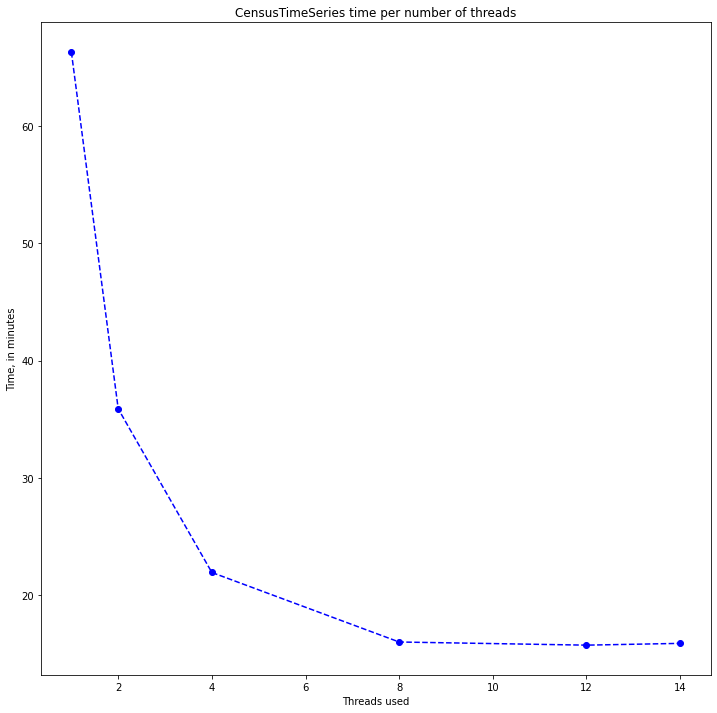

In [8]:
import time

threads = [1, 2, 4, 8, 12, 14]
times = []

for thread_pool in threads:
    print("Starting {} thread run".format(thread_pool))
    start_time = time.time()
    ts = CensusTimeSeries(shp_file, apikey)
    df = ts.get_timeseries(0, polygons=polygon, verbose=0, multithread=True, thread_pool=thread_pool)
    end_time = time.time()
    t = (end_time - start_time) / 60.
    times.append(t)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('CensusTimeSeries time per number of threads')
ax.set_ylabel("Time, in minutes")
ax.set_xlabel("Threads used")
ax.plot(threads, times, "bo--");